# Stochastic optimization landscape of a minimal MLP


In this notebook, we will try to better understand how stochastic gradient works. We fit a very simple non-convex model to data generated from a linear ground truth model.

We will also observe how the (stochastic) loss landscape changes when selecting different samples.

In [355]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import mse_loss

import numpy as np

from torch.autograd import Variable
from torch.nn.functional import relu

Data is generated from a simple model:
$$y=  2x + \epsilon$$

where:

- $\epsilon \sim \mathcal{N}(0, .1)$
- $x \sim \mathcal{U}(-1, 1)$

In [356]:
def sample_from_ground_truth(n_samples=100, std=0.1):
    x = torch.FloatTensor(n_samples, 1).uniform_(-1, 1)
    epsilon = torch.FloatTensor(n_samples, 1).normal_(0, std)
    y = 2 * x + epsilon
    return x, y

n_samples = 100
std = 3
x, y = sample_from_ground_truth(n_samples=100, std=std)

We propose a minimal single hidden layer perceptron model with a single hidden unit and no bias. The model has two tunable parameters $w_1$, and $w_2$, such that:

$$f(x) = w_1 \cdot \sigma(w_2 \cdot x)$$

where $\sigma$ is the ReLU function.

In [357]:
class SimpleMLP(nn.Module):
    def __init__(self, w=None):
        super(SimpleMLP, self).__init__()
        self.w1 = Parameter(torch.FloatTensor((1, )))
        self.w2 = Parameter(torch.FloatTensor((1, )))
        if w is None:
            self.reset_parameters()
        else:
            self.set_parameters(w)

    def reset_parameters(self):
        self.w1.data.uniform_(-.1, .1)
        self.w2.data.uniform_(-.1, .1)

    def set_parameters(self, w):
        self.w1.data[0] = w[0]
        self.w2.data[0] = w[1]

    def forward(self, x):
        return self.w1 * relu(self.w2 * x)        

As in the previous notebook, we define a function to sample from and plot loss landscapes.

In [358]:
from math import fabs

def make_grids(x, y, exp_risk_func, grid_size=100):
    n_samples = len(x)
    assert len(x) == len(y)

    # Grid logic
    x_max, y_max, x_min, y_min = 5, 5, -5, -5
    w1 = np.linspace(x_min, x_max, grid_size, dtype=np.float32)
    w2 = np.linspace(y_min, y_max, grid_size, dtype=np.float32)
    W1, W2 = np.meshgrid(w1, w2)
    W = np.concatenate((W1[:, :, None], W2[:, :, None]), axis=2)
    W = torch.from_numpy(W)

    # We will store the results in this tensor
    risks = torch.FloatTensor(n_samples, grid_size, grid_size)
    exp_risk = torch.FloatTensor(grid_size, grid_size)

    # Make x a variable. volatile=True tells pytorch to keep no
    # information for gradient computation.
    x = Variable(x, volatile=True)
    y = Variable(y, volatile=True)

    for i in range(grid_size):
        for j in range(grid_size):
            model = SimpleMLP(W[i, j])
            pred = model(x)
            loss = mse_loss(pred, y, reduce=False).data
            risks[:, i, j] = loss
            exp_risk[i, j] = exp_risk_func(W[i, j, 0], W[i, j, 1])
    emp_risk = torch.mean(risks, dim=0)
    
    
    return W1, W2, risks, emp_risk, exp_risk

def exp_risk_simple_mlp(w1, w2):
    return .5 * (8 / 3 - (4 / 3) * w1 * w2 + 1 / 3 * w1 ** 2 * w2 ** 2) + std ** 2

- `risks[k, i, j]` holds the single sample loss value $\ell(f(w_1 = i , w_2 = j, x_k), y_k)$

- `emp_risk[i, j]` corresponds to the empirical risk:

$$ \frac{1}{n} \sum_{k=1}^{n} \ell(f(w_1 = i , w_2 = j, x_k), y_k)$$

In [359]:
W1, W2, risks, emp_risk, exp_risk = make_grids(x, y, exp_risk_func=exp_risk_simple_mlp)

Let's define our train loop and train our model

In [360]:
from torch.optim import SGD, Adam

def train(model, x, y, lr=.1, n_epochs=1):
    optimizer = SGD(model.parameters(), lr=lr)
    iterate_rec = []
    grad_rec = []
    for epoch in range(n_epochs):
        for this_x, this_y in zip(x, y):
            this_x = this_x[None, :]
            this_y = this_y[None, :]
            this_x = Variable(this_x)
            this_y = Variable(this_y)
            optimizer.zero_grad()
            pred = model(this_x)
            loss = mse_loss(pred, this_y)
            loss.backward()
            iterate_rec.append([model.w1.data[0], model.w2.data[0]])
            grad_rec.append([model.w1.grad.data[0], model.w2.grad.data[0]])
            optimizer.step()
    return np.array(iterate_rec), np.array(grad_rec)

init = torch.FloatTensor([1.2, -4])
model = SimpleMLP(init)
iterate_rec, grad_rec = train(model, x, y, lr=.01)

We now plot:
- the sample risk at iteration $k$ on the left plot
- the empirical risk on the center plot
- the expected risk on the right plot

Observe how empirical and expected risk differ, and how empirical risk minimization is not totally equivalent to expected risk minimization.

In [375]:
def plot_map(W1, W2, risks, emp_risk, exp_risk, sample, iter_):
    saddle = exp_risk[50, 50]
    exp_risk -= saddle
    emp_risk -= saddle
    risks -= saddle
    cat_risks = np.concatenate((exp_risk.numpy().ravel(), emp_risk.numpy().ravel()))
    pos_levels = np.percentile(cat_risks[cat_risks > 0], q=np.linspace(0, 100, 5))
    neg_levels = np.percentile(cat_risks[cat_risks < 0], q=np.linspace(0, 100, 5))
    levels = np.concatenate([neg_levels, np[0], pos_levels])
    print(levels)
    vmin = levels[0]
    vmax = levels[-1]
    cmap = plt.get_cmap('RdBu_r')
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
#     risk_levels = np.percentile(risks[sample].numpy().ravel(), q=np.linspace(0, 100, 10))
#     risk_levels = np.unique(risk_levels)
    risk_levels = levels.copy()
    risk_levels[0] = min(risks[sample].numpy().min(), risk_levels[0])
    risk_levels[-1] = max(risks[sample].numpy().max(), risk_levels[-1])
    ax1.contourf(W1, W2, risks[sample], levels=risk_levels, vmin=vmin, vmax=vmax, cmap=cmap)
    ax1.scatter(iterate_rec[iter_, 0], iterate_rec[iter_, 1], color='orange', label='Gradient')
    ax1.arrow(iterate_rec[iter_, 0], iterate_rec[iter_, 1], -5 * grad_rec[iter_, 0], -5 * grad_rec[iter_, 1],
      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
    ax1.legend()
    ax1.set_title('Pointwise risk')
    ax2.contourf(W1, W2, emp_risk, levels=levels, vmin=vmin, vmax=vmax, cmap=cmap)
    ax2.plot(iterate_rec[:iter_ + 1, 0], iterate_rec[:iter_ + 1, 1], linestyle='-', marker='o', markersize=6,
             color='orange', linewidth=2, label='SGD trajectory')
    ax2.legend()
    ax2.set_title('Empirical risk')
    ax3.contourf(W1, W2, exp_risk, levels=levels, vmin=vmin, vmax=vmax, cmap=cmap)
    ax3.scatter(iterate_rec[iter_, 0], iterate_rec[iter_, 1], color='orange', label='Current sample')
    ax3.set_title('Expected risk')
    ax3.legend()
    fig.suptitle('Iter %i, sample % i' % (iter_, sample))
    plt.show()

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


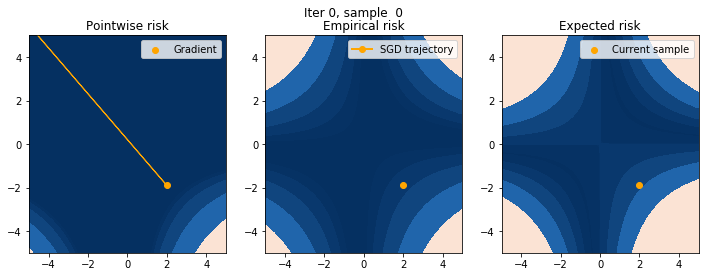

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


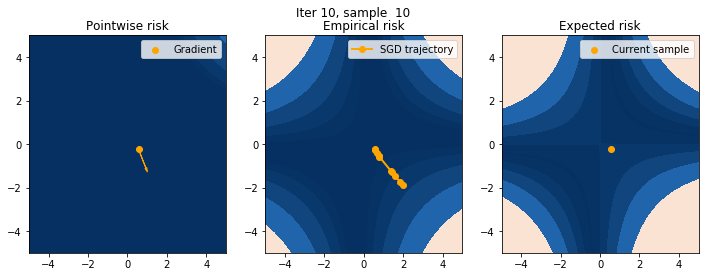

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


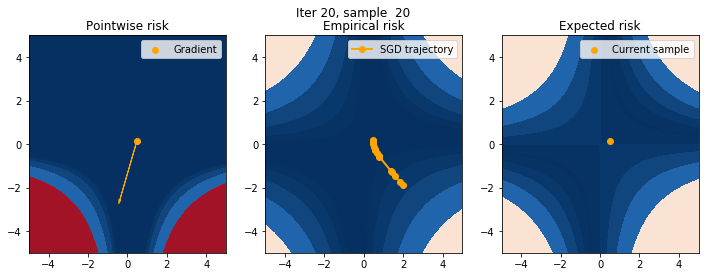

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


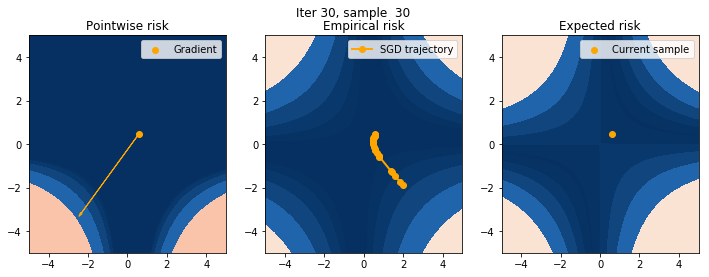

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


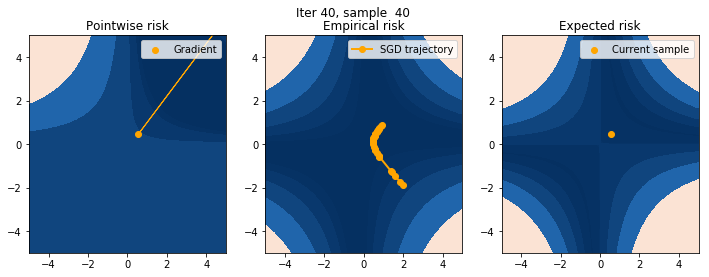

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


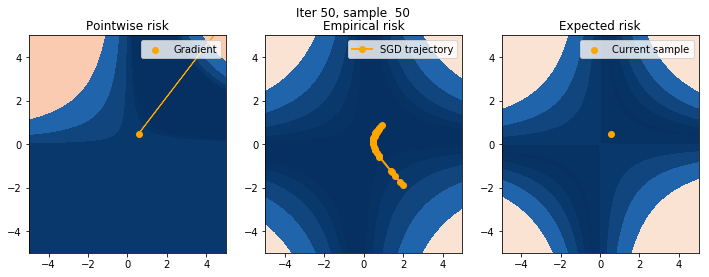

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


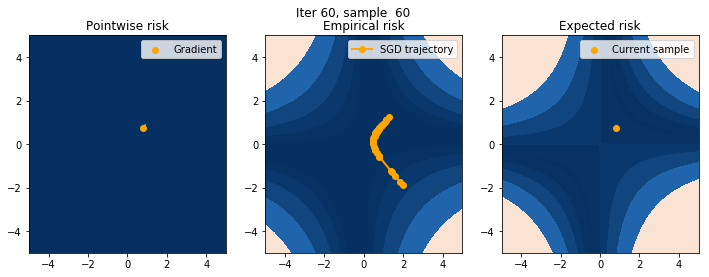

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


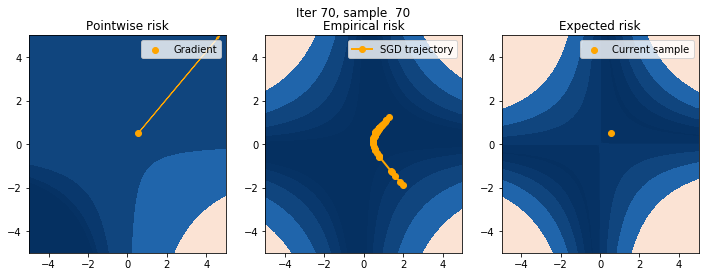

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


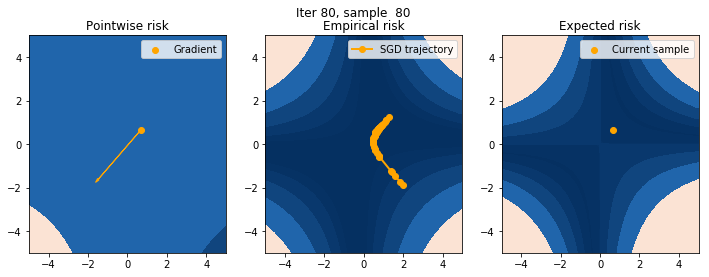

[-2.12972546e+00 -1.83680344e+00 -1.29926300e+00 -7.94395447e-01
 -5.04875183e-03  1.33895874e-03  3.40186214e+00  1.18703852e+01
  3.32950897e+01  2.41670059e+02]


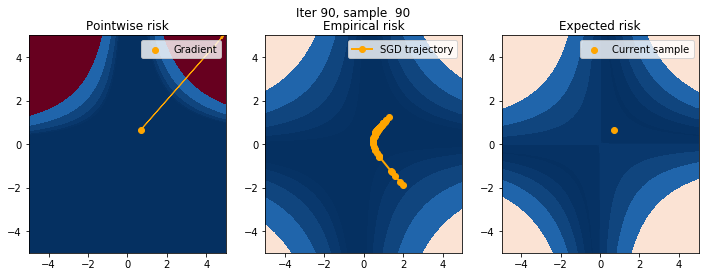

In [376]:
%matplotlib inline
for sample in range(0, 100, 10):
    plot_map(W1, W2, risks, emp_risk, exp_risk, sample, sample)

Uncomment for an interactive version of the plots above if ipywidgets works on your computer

In [363]:
%matplotlib inline
from functools import partial
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def plot_func(sample):
    plot_map(W1=W1, W2=W2, risks=risks, emp_risk=emp_risk, exp_risk=exp_risk, sample=sample, iter_=sample)
interactive_plot = interactive(plot_func, sample=(0, 99))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=49, description='sample', max=99), Output()), _dom_classes=('widget-interact',))

Observe and comment.

### Exercices:

- Change the model to a completely linear one and reproduce the plots. What do you observe regarding the stochastic gradient ?
- Try changing the optimizer. Is it useful in this case ?
- Try to initialize the model with pathological weights, e.g., symmetric ones. What do you observe ?
- You may increase the number of epochs to observe slow convergence phenomena
- Try augmenting the noise in the dataset. What do you observe ?

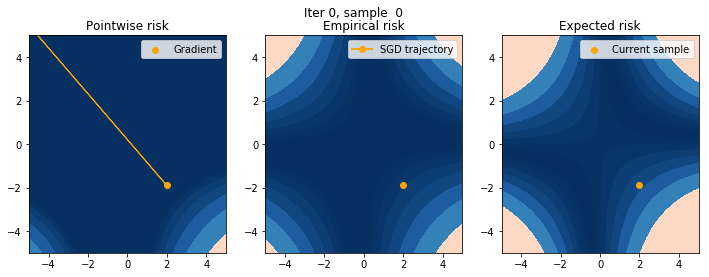

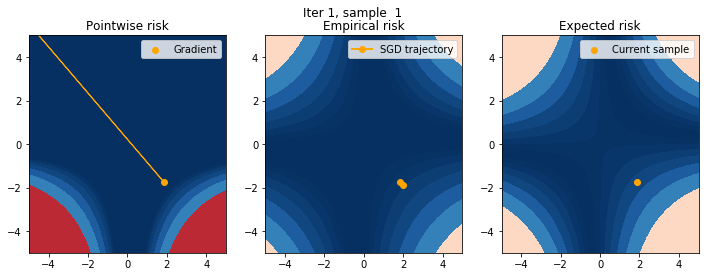

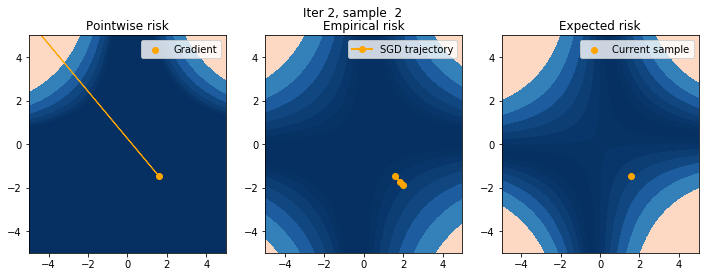

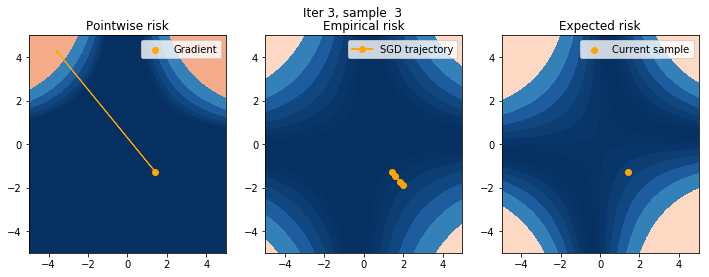

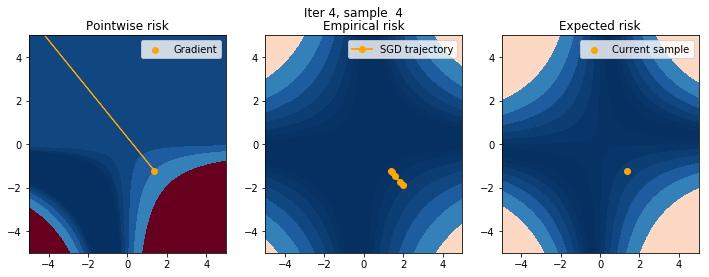

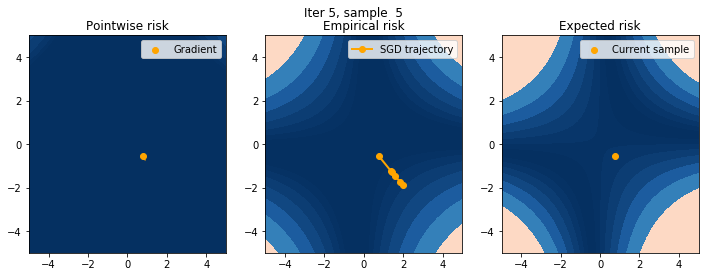

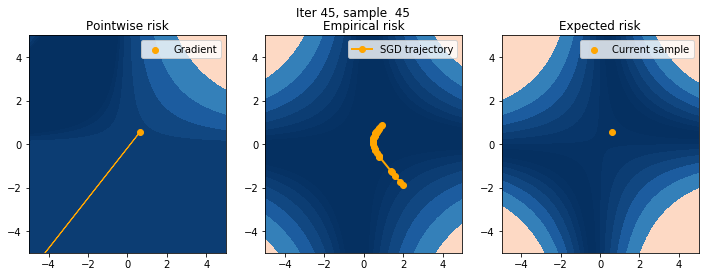

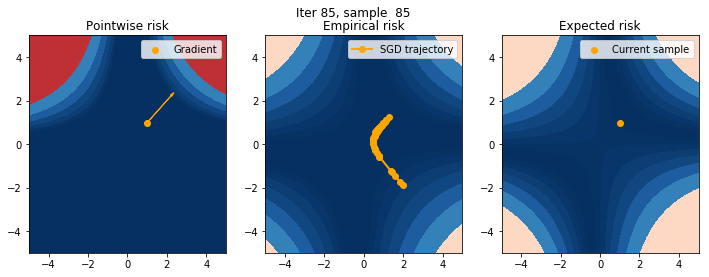

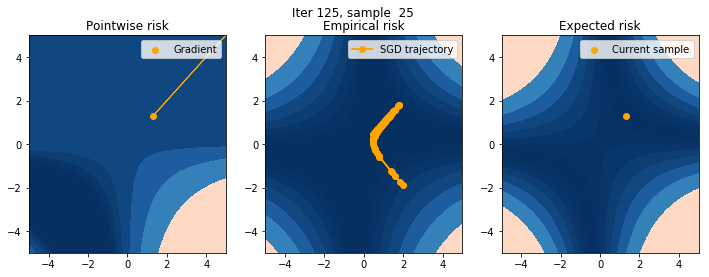

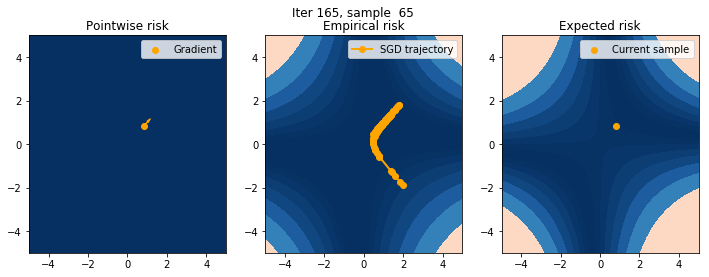

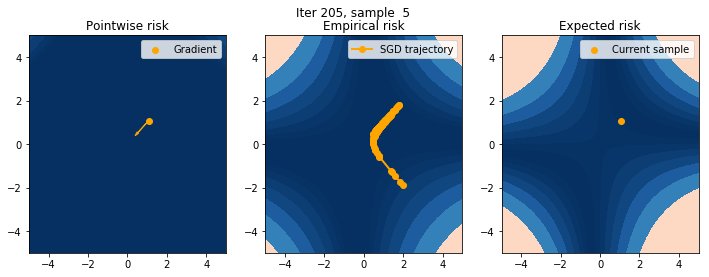

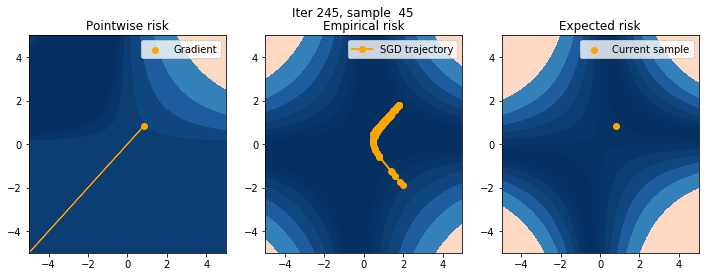

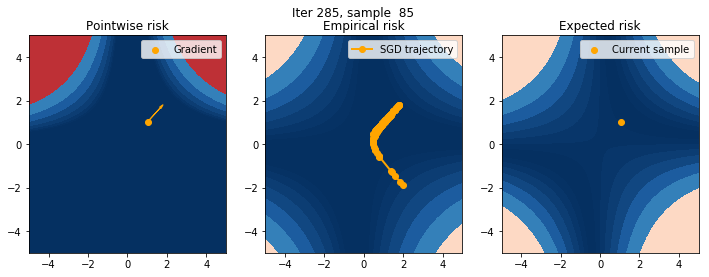

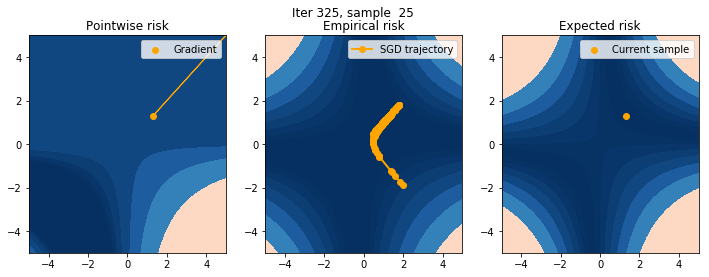

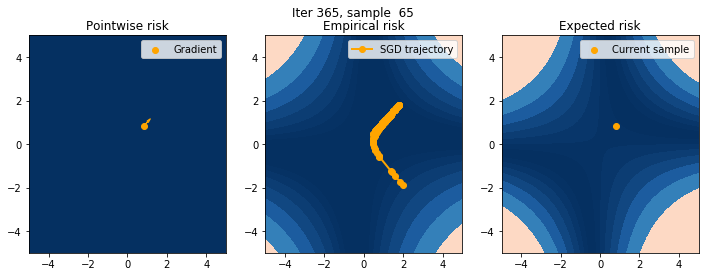

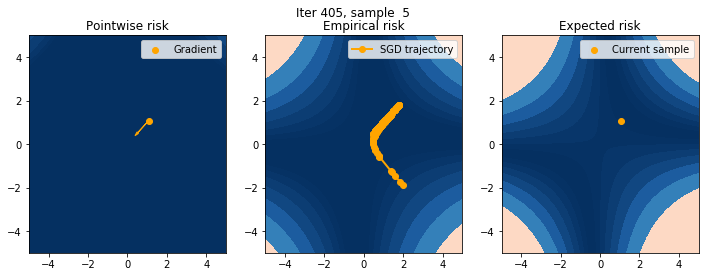

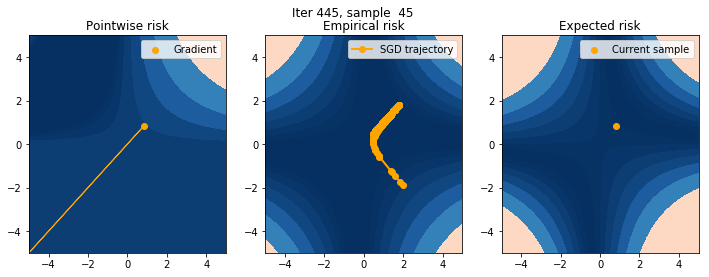

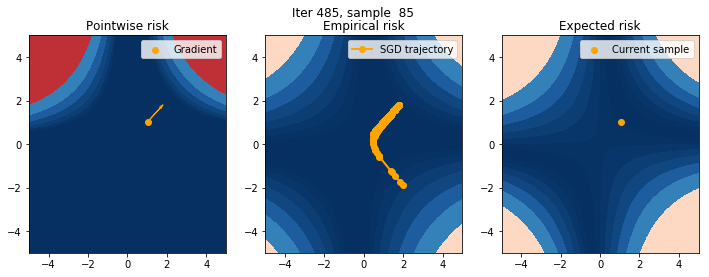

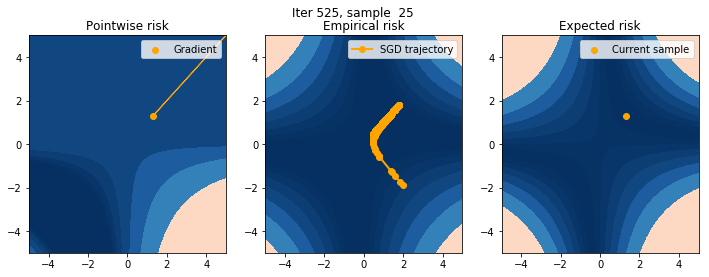

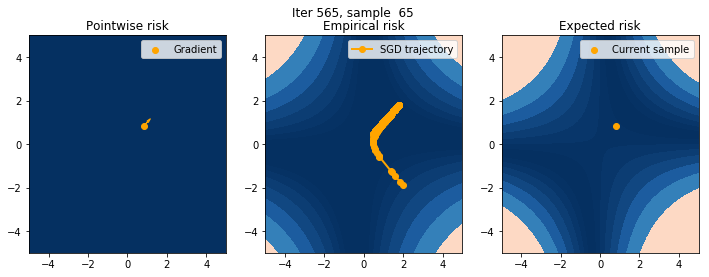

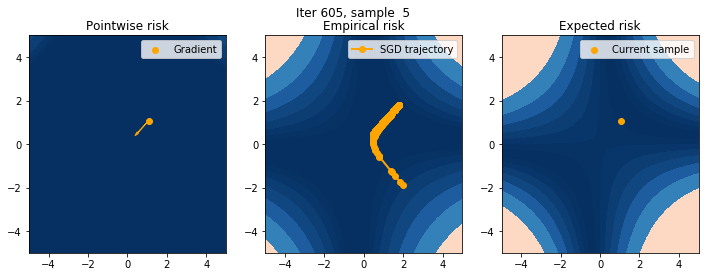

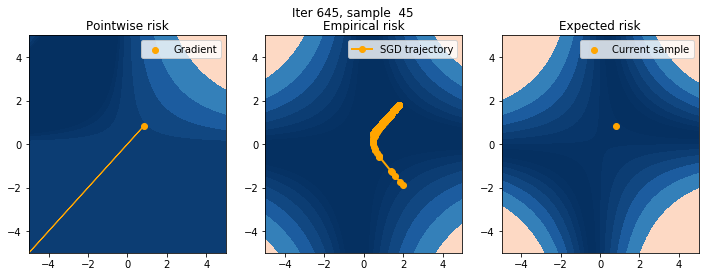

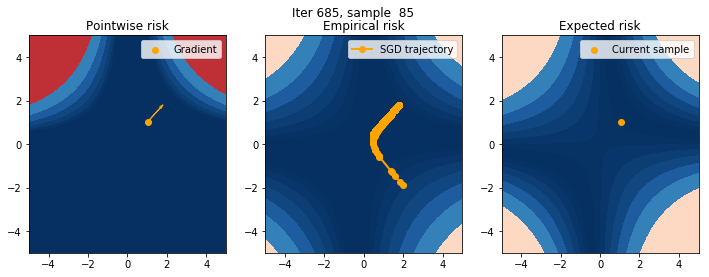

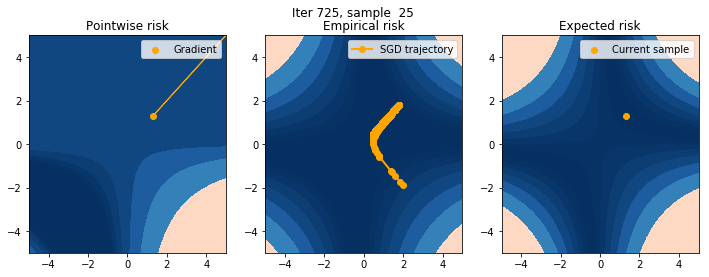

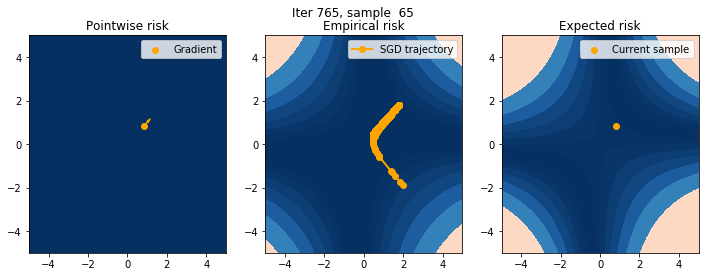

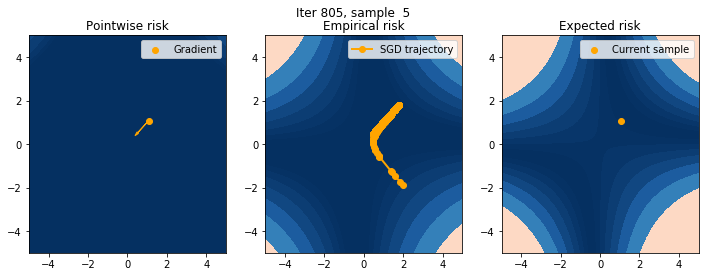

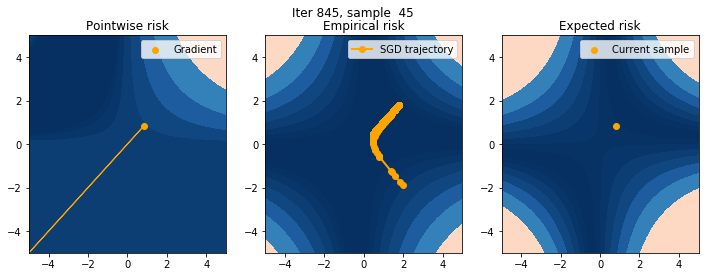

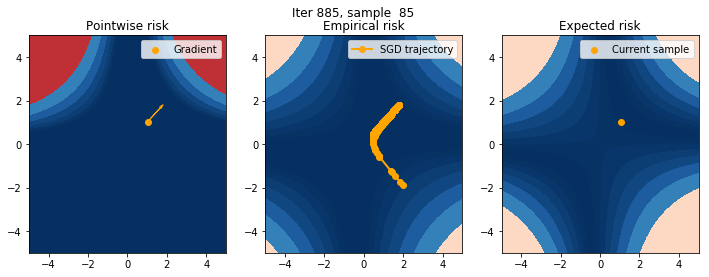

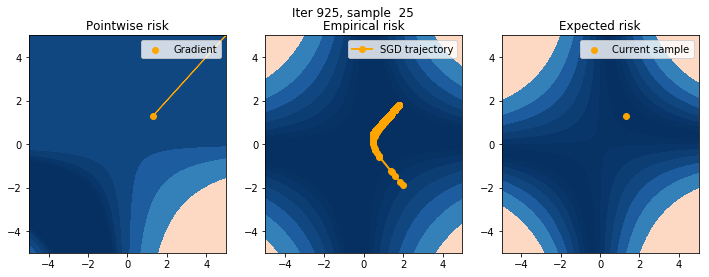

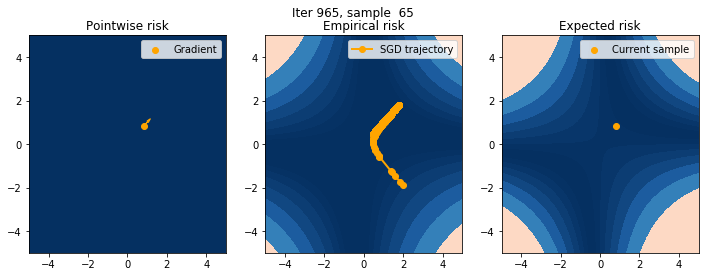

In [366]:
# %load solutions/linear_mlp.py
class LinearMLP(nn.Module):
    def __init__(self, w=None):
        super(LinearMLP, self).__init__()
        self.w1 = Parameter(torch.FloatTensor((1, )))
        self.w2 = Parameter(torch.FloatTensor((1, )))
        if w is None:
            self.reset_parameters()
        else:
            self.set_parameters(w)

    def reset_parameters(self):
        self.w1.data.uniform_(-.1, .1)
        self.w2.data.uniform_(-.1, .1)

    def set_parameters(self, w):
        self.w1.data[0] = w[0]
        self.w2.data[0] = w[1]

    def forward(self, x):
        return self.w1 * self.w2 * x
    
def exp_risk_linear_mlp(w1, w2):
    return .5 * (8 / 3 - (8 / 3) * w1 * w2 + 2 / 3 * w1 ** 2 * w2 ** 2) + std ** 2

W1, W2, risks, emp_risk, exp_risk = make_grids(x, y, exp_risk_func=exp_risk_linear_mlp)
init = torch.FloatTensor([2, -1.9])
model = LinearMLP(init)
iterate_rec, grad_rec = train(model, x, y, lr=.05, n_epochs=10)
n_iter = len(iterate_rec)
for iter_ in list(range(5)) + list(range(5, n_iter, 40)):
    sample = iter_ % n_samples
    plot_map(W1, W2, risks, emp_risk, exp_risk, sample, iter_)